# Compliance Plot

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from obspy import UTCDateTime

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"


## Methods

In [4]:
compl_FUR = pd.read_pickle(config['path_to_data']+"compliance_FUR.pkl")

compl_ROMY = pd.read_pickle(config['path_to_data']+"compliance_ROMY.pkl")


## Compliance Plot

In [5]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    scaling = 9.81 / (2*np.pi*compl_FUR['fc'])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5))

    ax.plot(compl_FUR['fc'], compl_FUR['Z'], label="FUR.Z", marker=".")
    ax.plot(compl_FUR['fc'], compl_FUR['N'], label="FUR.N", marker=".")
    ax.plot(compl_FUR['fc'], compl_FUR['E'], label="FUR.E", marker=".")


    ax.plot(compl_ROMY['fc'], compl_ROMY['Z']*scaling, label="ROMY.Z", ls="-", marker="x")
    ax.plot(compl_ROMY['fc'], compl_ROMY['N']*scaling, label="ROMY.N", ls="-", marker="x")
    ax.plot(compl_ROMY['fc'], compl_ROMY['E']*scaling, label="ROMY.E", ls="-", marker="x")


    ax.grid(axis="both", which="both", ls=":", zorder=0)
    ax.legend(loc=4, ncol=2)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(1e-3, 2e-1)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_ylabel("Compliance (nm /s$^2$ /hPa)", fontsize=font)

    plt.show();
    return fig

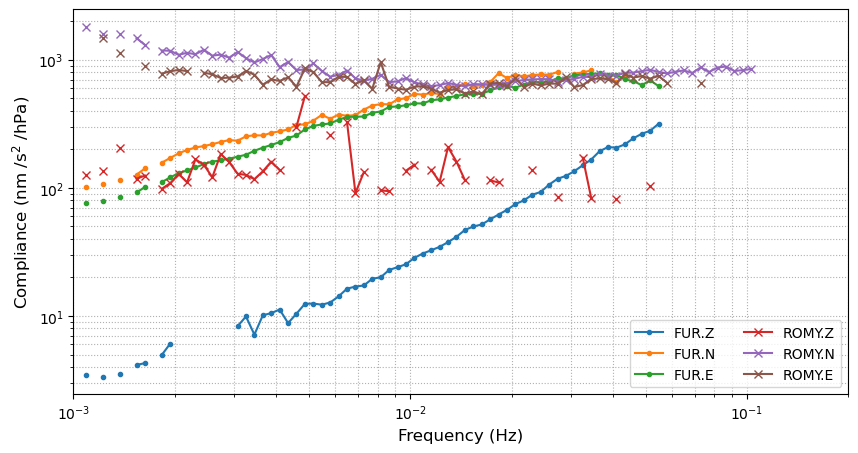

In [6]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"compliance.png", format="png", dpi=150, bbox_inches='tight')


In [7]:
os.system("""spd-say "Finished" """)

0